# 1. Sorting Fixed Length Lists with One Head

## Variable hyperparameters

In [1]:
# Fixed length of list to be sorted
LIST_LENGTH = 5

# Size of vocabulary
D_VOCAB = 66

# Should lists have repetitions?
ALLOW_REPETITIONS = False

# Attention only? (False -> model includes MLPs)
ATTN_ONLY = True

# Model dimenions
N_LAYERS = 1
N_HEADS = 1
D_MODEL = 128
D_HEAD = 32
D_MLP = None

if ATTN_ONLY:
    D_MLP = None

# Default batch size
DEFAULT_BATCH_SIZE = 32

# If you want to use pretrained weights, replace None by the path to the pkl file.
path_pkl_pretrained_weights = None

## Prelude

### Install and import

In [2]:
try:
    import transformer_lens
except:
    !pip install git+https://github.com/neelnanda-io/TransformerLens
    !pip install circuitsvis

In [3]:
from __future__ import annotations
from dataclasses import dataclass, field
from datetime import datetime as dt
from itertools import repeat
import os
import pickle
import random
from typing import cast, Generator, Literal
from copy import deepcopy

import circuitsvis as cv
from fancy_einsum import einsum
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn, tensor, Tensor, TensorType as TT
from torch.nn import functional as F
from transformer_lens import HookedTransformerConfig, HookedTransformer
from tqdm import tqdm
from typing_extensions import Self

cv.examples.hello("You")

### Invariable hyperparameters

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE = }")

# Seeds to generate training, validation, and test data
TRAIN_SEED = 42
VAL_SEED = 66
TEST_SEED = 1729

# Context length: [start, *(unsorted_)list_length, mid, *(sorted_)list_length]
N_CTX = 2 * LIST_LENGTH + 2

# "Real" tokens range from 0 to D_VOCAB - 2 (non-inclusive)
VOCAB_MIN_ID = 0
VOCAB_MAX_ID = D_VOCAB - 2

# START token is D_VOCAB - 2 and MID token is D_VOCAB - 1
START_TOKEN_ID = VOCAB_MAX_ID
MID_TOKEN_ID = D_VOCAB - 1

DEVICE = 'cpu'


### Data generator and datasets

In [5]:
def generate_list(batch_size: int) -> Tensor:
    if ALLOW_REPETITIONS:
        return torch.randint(VOCAB_MIN_ID, VOCAB_MAX_ID, (batch_size, LIST_LENGTH)).to(DEVICE)
    return tensor([
        random.sample(range(VOCAB_MIN_ID, VOCAB_MAX_ID), k=LIST_LENGTH) 
        for _ in range(batch_size)
    ]).to(DEVICE)

# General generator
def make_data_gen(
    *,
    batch_size: int = DEFAULT_BATCH_SIZE,
    dataset: Literal["train", "val", "test"], # probably this arg needs a better name,
) -> Generator[Tensor, None, None]:
    assert dataset in ("train", "val", "test")
    if dataset == "train":
        seed = TRAIN_SEED
    elif dataset == "val":
        seed = VAL_SEED
    else: # test
        seed = TEST_SEED
    torch.manual_seed(seed)
    while True:
        # Generate random numbers
        x = generate_list(batch_size)
        # Sort
        x_sorted = torch.sort(x, dim=1).values
        # START tokens
        x_start = START_TOKEN_ID * torch.ones(batch_size, dtype=torch.int32).reshape(batch_size, -1).to(DEVICE)
        # MID tokens
        x_mid = MID_TOKEN_ID * torch.ones(batch_size, dtype=torch.int32).reshape(batch_size, -1).to(DEVICE)
        yield torch.cat((x_start, x, x_mid, x_sorted), dim=1)


# Training data generator (kinda wrapper)
def make_train_gen() -> Generator[Tensor, None, None]:
    """Make generator of training data"""
    return make_data_gen(batch_size=128, dataset="train")

# Validation and test data

val_data = next(make_data_gen(batch_size=1000, dataset="val"))
test_data = next(make_data_gen(batch_size=1000, dataset="test"))

### Loss function

In [6]:
def loss_fn(
    logits: Tensor, # [batch, pos, d_vocab] 
    tokens: Tensor, # [batch, pos] 
    return_per_token: bool = False
) -> Tensor: # scalar
    """"""
    # 
    sorted_start_pos = LIST_LENGTH + 2
    logits = logits[:, (sorted_start_pos-1):-1]
    tokens = tokens[:, sorted_start_pos : None]
    log_probs = logits.log_softmax(-1)
    correct_log_probs = log_probs.gather(-1, tokens[..., None])[..., 0]
    if return_per_token:
        return -correct_log_probs
    return -correct_log_probs.mean()

### Accuracy and validation

In [7]:
def get_diff_row_inds(
    a: Tensor, # [dim1, dim2]
    b: Tensor  # [dim1, dim2]
) -> Tensor:   # [dim1]
    """Find indices of rows where a and b differ"""
    assert a.shape == b.shape
    return ((a == b).prod(dim=1) == 0).nonzero(as_tuple=True)[0]

def acc_fn(
    logits: Tensor, # [batch, pos, d_vocab]
    tokens: Tensor, # [batch, pos]
    per: Literal["token", "sequence"] = "sequence"
) -> float:
    """Compute accuracy as percentage of correct predictions"""
    sorted_start_pos = LIST_LENGTH + 2
    # Get logits of predictions for position
    logits = logits[:, (sorted_start_pos-1):-1]
    preds = logits.argmax(-1)
    tokens = tokens[:, sorted_start_pos:]
    if per == "sequence":
        return (preds == tokens).prod(dim=1).float().mean().item()
    return (preds == tokens).float().mean().item()

def validate(
    model: HookedTransformer, 
    data: Tensor # [batch, pos]
) -> float:
    """Test this model on `data`"""
    logits = model(data)
    acc = acc_fn(logits, tokens=data)
    return acc

def show_mispreds(
    model: HookedTransformer, 
    data: Tensor # [batch, pos]
) -> None:
    """Test this model on `data` and print mispredictions"""
    logits = model(data)
    sorted_start_pos = LIST_LENGTH + 2
    logits = logits[:, (sorted_start_pos-1):-1]
    tokens = data[:, sorted_start_pos:].cpu()
    preds = logits.argmax(-1).cpu()
    mispred_inds = get_diff_row_inds(tokens, preds)
    for i in mispred_inds:
        print(f"[{i}] {tokens[i].numpy().tolist()} | {preds[i].numpy().tolist()}")
    print(f"{len(mispred_inds)}/{len(preds)} ({len(mispred_inds) / len(preds) :.2%})")

## Training

### Model

In [8]:
cfg = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=N_CTX,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=42,
    device=DEVICE,
    attn_only=ATTN_ONLY
)
model = HookedTransformer(cfg, move_to_device=True)

### Training setup

In [9]:
@dataclass(frozen=True)
class TrainingHistory:
    losses: list[float]
    train_accuracies: list[float]
    val_accuracies: list[float]

def converged(val_accs: list[float], n_last: int = 10) -> bool:
    return cast(bool, (tensor(val_accs[-n_last:]) == 1).all().item())

# Number of epochs
n_epochs = 20000

# Optimization
lr = 1e-3
betas = (.9, .999)
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, "min", patience=100)

# Training data generator
train_gen = make_train_gen()

def train_model(model: HookedTransformer) -> TrainingHistory:
    losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        tokens = next(train_gen).to(device=DEVICE)
        logits = model(tokens)
        loss = loss_fn(logits, tokens)
        loss.backward()
        optim.step()
        optim.zero_grad()
        scheduler.step(loss)
        
        if epoch % 100 == 0:
            losses.append(loss.item())
            train_batch_acc = acc_fn(logits, tokens)
            val_acc = validate(model, val_data)
            val_loss = loss_fn(model(val_data), val_data)

            train_accuracies.append(train_batch_acc)
            val_accuracies.append(val_acc)
            print(
                f"Epoch {epoch}/{n_epochs} ({epoch / n_epochs:.0%}) : "
                f"loss = {loss.item():.4f}; {train_batch_acc=:.3%}; "
                f"{val_acc=:.3%}; lr={scheduler._last_lr[0]}" #type:ignore
            )
            # If last 10 recorded val_accuracies are 100%
            if converged(val_accuracies):
                print(f"\nAchieved consistent perfect validation accuracy after {epoch} epochs")
                break
    return TrainingHistory(losses, train_accuracies, val_accuracies)

def load_model_state(model: HookedTransformer, filename: str) -> None:
    assert os.path.isdir("models"), "Make a directory `models` with model state dicts"
    if not filename.startswith("models/"):
        filename = f"models/{filename}"
    with open(filename, "rb") as f:
        state_dict = pickle.load(f)
    model.load_state_dict(state_dict)

### Train or load model

In [14]:
if path_pkl_pretrained_weights:
  load_model_state(model, path_pkl_pretrained_weights)
else:
  history = train_model(model)

Epoch 0/20000 (0%) : loss = 4.4918; train_batch_acc=0.000%; val_acc=0.000%; lr=0.001
Epoch 100/20000 (0%) : loss = 0.3355; train_batch_acc=55.469%; val_acc=56.800%; lr=0.001
Epoch 200/20000 (1%) : loss = 0.1063; train_batch_acc=85.938%; val_acc=88.800%; lr=0.001
Epoch 300/20000 (2%) : loss = 0.0371; train_batch_acc=97.656%; val_acc=95.800%; lr=0.001
Epoch 400/20000 (2%) : loss = 0.0298; train_batch_acc=98.438%; val_acc=98.000%; lr=0.001
Epoch 500/20000 (2%) : loss = 0.0135; train_batch_acc=100.000%; val_acc=98.500%; lr=0.001
Epoch 600/20000 (3%) : loss = 0.0120; train_batch_acc=99.219%; val_acc=99.600%; lr=0.001
Epoch 700/20000 (4%) : loss = 0.0130; train_batch_acc=99.219%; val_acc=99.400%; lr=0.001
Epoch 800/20000 (4%) : loss = 0.0094; train_batch_acc=100.000%; val_acc=99.000%; lr=0.001
Epoch 900/20000 (4%) : loss = 0.0083; train_batch_acc=99.219%; val_acc=99.400%; lr=0.001
Epoch 1000/20000 (5%) : loss = 0.0044; train_batch_acc=100.000%; val_acc=100.000%; lr=0.0001
Epoch 1100/20000 (6

### Testing post-training

In [15]:
print("Validating on validation data:")
val_acc = validate(model, val_data)
print(f"\t{val_acc=:.3%}\n")
if val_acc < 1:
    show_mispreds(model, val_data)

print("\nValidating on test data:")
test_acc = validate(model, test_data)
print(f"\t{test_acc=:.3%}\n")
if test_acc < 1:
    show_mispreds(model, test_data)

Validating on validation data:
	val_acc=100.000%


Validating on test data:
	test_acc=100.000%



### Saving trained model

In [28]:
def save_model_state_dict(
    model: HookedTransformer, 
    filename: str | None = None
) -> None:
    if not os.path.isdir("models"):
        os.mkdir("models")
    if not filename:
        timestamp = dt.now().isoformat("T", "minutes").replace(":", "-")
        filename = f"model_state_dict_{timestamp}.pkl"
    with open(f"models/{filename}", "wb") as f:
        pickle.dump(model.state_dict(), f)

save_model_state_dict(model)

In [30]:
os.listdir("models")

['model_state_dict_2023-01-22T08-48.pkl']

## Investigate the model

### Attention patterns

- "Normal" tokens (`[0, 63]`) attend to the tokens that are "greater" than them in the total order learned by the transformer. The model picks the one with the greatest score (which almost always is the smallest token bigger than the current token) copies it and proceeds.
    - The exception is the final token, whose attention seems random, because its predictions did not impact loss.
- The `START` token (`64`) attends only to itself. This seems obvious because being at the beginning of the sequence it has nothing else to attend to (the model is autoregressive). However, we will soon see how "malformed" inputs direct its attention.
- The `MID` token (`65`) attends to the smallest token. Thus, it can be seen as the start of sequence and the lowest value ("initial object").

In [19]:
# Get one input from test_data
test_input = test_data[3, :]

# Pass through model, get cache and predictions
logits, cache_model = model.run_with_cache(test_input, remove_batch_dim=True) 
preds = logits[:, LIST_LENGTH+1 : -1].argmax(-1)

# Get attention pattern and plot it
attention_pattern = cache_model["pattern", 0, "attn"]
tokens_input = list(map(str, test_input))
print(test_input)
print(preds)

cv.attention.attention_patterns(tokens=tokens_input, attention=attention_pattern)

tensor([64,  5, 13,  9, 19, 58, 65,  5,  9, 13, 19, 58])
tensor([[ 5,  9, 13, 19, 58]])


Now let's do the some with artificial input

In [20]:
# Artificial input
artificial_input = [6, 2, 59, 50, 20]
artificial_input = tensor([[64, *artificial_input, 65]])
artificial_input = model.generate(artificial_input,
                                  max_new_tokens=LIST_LENGTH,
                                  stop_at_eos=False
                                  ).clone().ravel()
print("Sorted artificial input:", artificial_input.numpy().tolist()[-LIST_LENGTH:])

# Pass through model, get cache and predictions
logits, cache_model = model.run_with_cache(artificial_input, remove_batch_dim=True) 
preds = logits[:, LIST_LENGTH+1 : -1].argmax(-1)

# Get attention pattern and plot it
attention_pattern = cache_model["pattern", 0, "attn"]
tokens_input = list(map(str, artificial_input))
print(artificial_input)
print(preds)
cv.attention.attention_patterns(tokens=tokens_input, attention=attention_pattern)

  0%|          | 0/5 [00:00<?, ?it/s]

Sorted artificial input: [2, 6, 20, 50, 59]
tensor([64,  6,  2, 59, 50, 20, 65,  2,  6, 20, 50, 59])
tensor([[ 2,  6, 20, 50, 59]])


### Corruption tests

Now let's corrupt that input and see what happens.

#### 1. `START` injection

If we inject `START` somewhere later in the sequence, its attention seems to be distributed between bigger tokens? I don't know how to make sense of this but it's definitely not random.

In [24]:
start_injection_site = 8
test_input_i = 100

# Test input
test_input = test_data[test_input_i].detach().clone()
print("Sorted artificial input:", test_input.tolist()[-LIST_LENGTH:])

# Corrupt
test_input[start_injection_site] = START_TOKEN_ID

# Pass through model, get cache and predictions
logits, cache_model = model.run_with_cache(test_input, remove_batch_dim=True) 
preds = logits[:,LIST_LENGTH+1:-1].argmax(-1)

# Get attention pattern and plot it
attention_pattern = cache_model["pattern", 0, "attn"]
tokens_input = list(map(str, list(test_input)))
print(test_input.tolist())
print(preds.ravel().tolist())
cv.attention.attention_patterns(tokens=tokens_input, attention=attention_pattern)

Sorted artificial input: [13, 14, 33, 44, 46]
[64, 33, 13, 14, 44, 46, 65, 13, 64, 33, 44, 46]
[13, 14, 44, 44, 46]


#### 2. `START` deletion

Deleting the `START` token negatively impacts the model's ability to sort the list. It makes it more likely to repeat tokens, for example.

In [ ]:
test_input_i = 100

# Get test input without START and up to MID inclusive
test_input = test_data[test_input_i, 1:LIST_LENGTH+2]
print("After `START` deletion:", test_input.numpy().tolist())
test_input = model.generate(test_input.reshape(1, -1), 
                            max_new_tokens=LIST_LENGTH, 
                            stop_at_eos=False
                            ).clone().ravel()
print("Sorted artificial input:", test_input.numpy().tolist())


# Pass through model, get cache and predictions
logits, cache_model = model.run_with_cache(test_input, remove_batch_dim=True) 
preds = logits[:,-LIST_LENGTH-1:-1].argmax(-1)

# Get attention pattern and plot it
attention_pattern = cache_model["pattern", 0, "attn"]
tokens_input = list(map(str, list(test_input)))
print(test_input)
print(preds)
cv.attention.attention_patterns(tokens=tokens_input, attention=attention_pattern)

After `START` deletion: [25, 18, 50, 2, 57, 65]


  0%|          | 0/5 [00:00<?, ?it/s]

Sorted artificial input: [25, 18, 50, 2, 57, 65, 2, 2, 18, 50, 57]
tensor([25, 18, 50,  2, 57, 65,  2,  2, 18, 50, 57])
tensor([[ 2,  2, 18, 50, 57]])


#### 3. `MID` injection

Attention of the `MID` token injected within the sorted sentence seems kinda confused/disorganized.

In [ ]:
mid_injection_site = 8
test_input_i = 190

# Test input
test_input = deepcopy(test_data[test_input_i])
print("Sorted artificial input:", test_input.numpy().tolist()[-LIST_LENGTH:])

# Corrupt
test_input[mid_injection_site] = MID_TOKEN_ID

# Pass through model, get cache and predictions
logits, cache_model = model.run_with_cache(test_input, remove_batch_dim=True) 
preds = logits[:,-LIST_LENGTH-1:-1].argmax(-1)

# Get attention pattern and plot it
attention_pattern = cache_model["pattern", 0, "attn"]
tokens_input = list(map(str, list(test_input)))
print(test_input)
print(preds)
cv.attention.attention_patterns(tokens=tokens_input, attention=attention_pattern)

Sorted artificial input: [5, 21, 31, 40, 57]
tensor([64, 57,  5, 31, 40, 21, 65,  5, 65, 31, 40, 57])
tensor([[ 5, 21,  5, 40, 57]])


#### 4. `MID` deletion

Upon deleting the `MID`, the model often can still sort the list `[START, *LIST_ + LIST_LENGTH of normal tokens]` (although there is some degree of randomness and it makes some mistakes). It just copies one of the normal tokens and treats it as `MID` token. Most likely it uses positional encoding to keep track of list length.

In [ ]:
test_input_i = 999

# Get test input up to MID exclusive
test_input = test_data[test_input_i, :LIST_LENGTH+1]
print("After `MID` deletion:", test_input.cpu().numpy().tolist())
test_input = model.generate(test_input.reshape(1, -1), 
                            max_new_tokens=LIST_LENGTH+1, 
                            stop_at_eos=False
                            ).clone().ravel()
print("Sorted artificial input:", test_input.cpu().numpy().tolist())

print(test_input.shape)

# Pass through model, get cache and predictions
logits, cache_model = model.run_with_cache(test_input, remove_batch_dim=True) 
preds = logits[:,-LIST_LENGTH-1:-1].argmax(-1)

# Get attention pattern and plot it
attention_pattern = cache_model["pattern", 0, "attn"]
tokens_input = list(map(str, list(test_input)))
print("Logit preds:", preds.cpu().numpy().tolist())
cv.attention.attention_patterns(tokens=tokens_input, attention=attention_pattern)

After `MID` deletion: [64, 59, 4, 51, 23, 6]


  0%|          | 0/6 [00:00<?, ?it/s]

Sorted artificial input: [64, 59, 4, 51, 23, 6, 4, 6, 23, 51, 59, 59]
torch.Size([12])
Logit preds: [[6, 23, 51, 59, 59]]


### Looking at weights

We embed all `D_VOCAB` tokens, obtaining the matrix `all_token_embeddings` of shape `[D_VOCAB D_MODEL]`. We multiply it with matrices of weights for keys and queries from the (only) attention and multiply these results again in order to obtain the map that queries of each token (x axis) tend to pay to keys of other tokens preceeding them (y axis).

We can observe several things:

- Tokens tend to pay the most attention to their most immediate followers (in their total ordering) and very little attention, hence the bright yellow hue below the main diagonal.
- `START` token's attention seems kind of random.
- `MID` token's attention is inversely proportional to the token's position in the ordering (i.e. number magnitude).

Note that this matrix/heatmap is not symmetrical, since how much attention token X pays to token Y may be (and in this case is) different from how much attention token Y pays to token X.

Of course, this is an approximation: we didn't take into account the positional encoding.

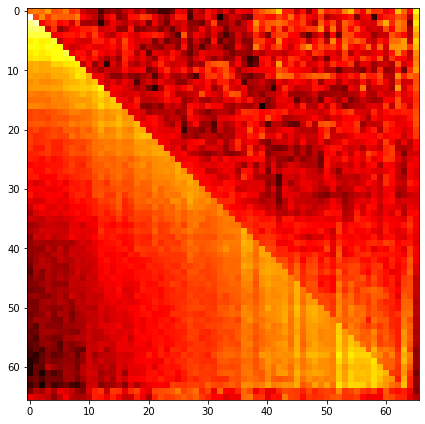

In [ ]:
attn = model.blocks[0].attn
all_token_embeddings = model.embed(range(D_VOCAB))

embeddings_key = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                        all_token_embeddings, attn.W_K) 
embeddings_query = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                          all_token_embeddings, attn.W_Q) 
                          
plt.rcParams['figure.figsize'] = [20, 10]
qk_circuit_attn_heatmap = einsum(
    "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> ... d_vocab_q d_vocab_k", 
    embeddings_query, embeddings_key
    ).detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(qk_circuit_attn_heatmap, cmap="hot", interpolation="nearest")
plt.colorbar(graph)
plt.tight_layout()